# Import Dependencies

In [58]:
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import chardet
import requests
import numpy as np
import matplotlib
from matplotlib import pyplot, style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

from secrets import mysql_password, api_key

# Extract: Import files/create dataframes

In [2]:
#------------------------Extract: CSV Arrival Data----------------------------#
#(This file contains number of arrivals by travelers, per year up to 2018)#

arrivals_file = "resources/data/travel/API_ST.INT.ARVL_DS2_en_csv_v2_10515875.csv"
arrivals_df = pd.read_csv(arrivals_file , encoding = 'latin-1')
arrivals_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,813000.0,824000.0,869000.0,904000.0,979000.0,1072000.0,1225000.0,1102000.0,1070500.0,NaN
1,Afghanistan,AFG,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,366000.0,425000.0,481000.0,528000.0,650000.0,595000.0,592000.0,397000.0,261000.0,NaN
3,Albania,ALB,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,1711000.0,2191000.0,2469000.0,3156000.0,2857000.0,3341000.0,3784000.0,4070000.0,4643000.0,NaN
4,Andorra,AND,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,1830000.0,1808000.0,2242000.0,2238000.0,2328000.0,2363000.0,2663000.0,2831000.0,NaN,NaN


In [3]:
#----------------------------------Extract: CSV metadata file-----------------------------------------#
#(This file contains country code column, and some demographic info such as region & income group)#

metadata_file =  "resources/data/travel/Metadata_Country_API_ST.INT.ARVL_DS2_en_csv_v2_10515875.csv"
metadata_df = pd.read_csv(metadata_file, encoding='utf-8')
metadata_df.head()

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,Mining is included in agriculture\nElectricty ...,Aruba,NaN
1,AFG,South Asia,Low income,Fiscal year end: March 20; reporting period fo...,Afghanistan,NaN
2,AGO,Sub-Saharan Africa,Lower middle income,NaN,Angola,NaN
3,ALB,Europe & Central Asia,Upper middle income,NaN,Albania,NaN
4,AND,Europe & Central Asia,High income,WB-3 code changed from ADO to AND to align wit...,Andorra,NaN


In [4]:
#------------------------Extract: CSV happiness file-----------------------------#
#(This file contains region, population, area size, GDP, mortality and more)#
happiness_file = "resources/data/happiness/2017_Happiness.csv"
happiness_df = pd.read_csv(happiness_file)
happiness_df.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [5]:
#Extract happiness index JSON file and read in. Note that Coastline contains a dict within a dict
json_file = "resources/data/happiness/convertcsv.json"
country_facts_df = pd.read_json(json_file)
country_facts_df.head()

,Agriculture,Arable (%),Area (sq. mi.),Birthrate,Climate,Coastline (coast,Country,Crops (%),Deathrate,GDP ($ per capita),Industry,Infant mortality (per 1000 births),Literacy (%),Net migration,Other (%),Phones (per 1000),Pop. Density (per sq. mi.),Population,Region,Service
0,0.380,12.13,647500,46.60,1.0,{'area ratio)': 0},Afghanistan,0.22,20.34,700.0,0.240,163.07,36.0,23.06,87.65,3.2,48.0,31056997,ASIA (EX. NEAR EAST),0.380
1,0.232,21.09,28748,15.11,3.0,{'area ratio)': 1.26},Albania,4.42,5.22,4500.0,0.188,21.52,86.5,-4.93,74.49,71.2,124.6,3581655,EASTERN EUROPE,0.579
2,0.101,3.22,2381740,17.14,1.0,{'area ratio)': 0.04},Algeria,0.25,4.61,6000.0,0.600,31.00,70.0,-0.39,96.53,78.1,13.8,32930091,NORTHERN AFRICA,0.298
3,NaN,10.00,199,22.46,2.0,{'area ratio)': 58.29},American Samoa,15.00,3.27,8000.0,NaN,9.27,97.0,-20.71,75.00,259.5,290.4,57794,OCEANIA,NaN
4,NaN,2.22,468,8.71,3.0,{'area ratio)': 0},Andorra,0.00,6.25,19000.0,NaN,4.05,100.0,6.60,97.78,497.2,152.1,71201,WESTERN EUROPE,NaN


In [6]:
#---------------------Extract: CSV birthrate file---------------------------#
csv_file = "resources/data/birthrate/crude_birthrate.csv"
birthrate_df = pd.read_csv(csv_file)
birthrate_df.head()

,Series Name,Series Code,Country Name,Country Code,2016 [YR2016],2017 [YR2017],2018 [YR2018]
0,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Afghanistan,AFG,33.214,..,..
1,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Albania,ALB,11.816,..,..
2,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Algeria,DZA,23.132,..,..
3,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,American Samoa,ASM,..,..,..
4,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Andorra,AND,8.8,..,..


In [7]:
#---------------------Extract: CSV Economic files---------------------------#
csv_file_2019= "resources/data/economic/Economic_Index_Data_2019.csv"
csv_file_2018= "resources/data/economic/Economic_Index_Data_2018.csv"
csv_file_2017= "resources/data/economic/Economic_Index_Data_2017.csv"
csv_file_2016= "resources/data/economic/Economic_Index_Data_2016.csv"
csv_file_2015= "resources/data/economic/Economic_Index_Data_2015.csv"
csv_file_2014= "resources/data/economic/Economic_Index_Data_2014.csv"
csv_file_2013= "resources/data/economic/Economic_Index_Data_2013.csv"
csv_file_2012= "resources/data/economic/Economic_Index_Data_2012.csv"
csv_file_2011= "resources/data/economic/Economic_Index_Data_2011.csv"
csv_file_2010= "resources/data/economic/Economic_Index_Data_2010.csv"
csv_file_2009= "resources/data/economic/Economic_Index_Data_2009.csv"
economic_index_2019_df = pd.read_csv(csv_file_2019)
economic_index_2018_df = pd.read_csv(csv_file_2018)
economic_index_2017_df = pd.read_csv(csv_file_2017)
economic_index_2016_df = pd.read_csv(csv_file_2016)
economic_index_2015_df = pd.read_csv(csv_file_2015)
economic_index_2014_df = pd.read_csv(csv_file_2014)
economic_index_2013_df = pd.read_csv(csv_file_2013)
economic_index_2012_df = pd.read_csv(csv_file_2012)
economic_index_2011_df = pd.read_csv(csv_file_2011)
economic_index_2010_df = pd.read_csv(csv_file_2010)
economic_index_2009_df = pd.read_csv(csv_file_2009)

In [9]:
#---------------------Extract: API country codes---------------------------#

# Get list of countries from country facts dataframe
country = arrivals_df['Country Name'].tolist()
type(country)

new_country = []

for c in country:
    c.rstrip()
    new_country.append(c.rstrip())

In [10]:
url = 'https://restcountries.eu/rest/v2/name/'
endstring = '?fullText=true'

name = []
cc_2 = []
cc_3 = []

for c in new_country:
    try:
        response = requests.get(url + c + endstring).json()
        name.append(response[0]['name'])
        cc_2.append(response[0]['alpha2Code'])
        cc_3.append(response[0]['alpha3Code'])
        print(response[0]['name'])
    
    except KeyError:
        print(f'City {c} not found. Skipping...')
        pass

Aruba
Afghanistan
Angola
Albania
Andorra
City Arab World not found. Skipping...
United Arab Emirates
Argentina
Armenia
American Samoa
Antigua and Barbuda
Australia
Austria
Azerbaijan
Burundi
Belgium
Benin
Burkina Faso
Bangladesh
Bulgaria
Bahrain
City Bahamas, The not found. Skipping...
Bosnia and Herzegovina
Belarus
Belize
Bermuda
City Bolivia not found. Skipping...
Brazil
Barbados
Brunei Darussalam
Bhutan
Botswana
Central African Republic
Canada
City Central Europe and the Baltics not found. Skipping...
Switzerland
City Channel Islands not found. Skipping...
Chile
China
Côte d'Ivoire
Cameroon
City Congo, Dem. Rep. not found. Skipping...
City Congo, Rep. not found. Skipping...
Colombia
Comoros
Cabo Verde
Costa Rica
City Caribbean small states not found. Skipping...
Cuba
Curaçao
Cayman Islands
Cyprus
Czech Republic
Germany
Djibouti
Dominica
Denmark
Dominican Republic
Algeria
City East Asia & Pacific (excluding high income) not found. Skipping...
City Early-demographic dividend not found

# Transform: Clean DataFrames

In [8]:
#------------Transform: Arrivals dataframe------------#

# First list columns and keep only columns we are interested in
list(arrivals_df)
new_arrivals_df = arrivals_df[['Country Name','Country Code','2008','2009','2010','2011','2012','2013','2014',\
 '2015','2016','2017','2018']]
new_arrivals_df.head()

# Noticed on inspection that there is no data for 2018 so will drop column
print(new_arrivals_df['2018'])
del new_arrivals_df['2018']
new_arrivals_df.head()

# Rename columns so that they are differentiated from other Dataframes
list(new_arrivals_df)

arrivals_renamed = {'Country Name':'Country Name',
 'Country Code': 'Country Code',
 '2008': 'Travel_2008',
 '2009': 'Travel_2009',
 '2010': 'Travel_2010',
 '2011': 'Travel_2011',
 '2012': 'Travel_2012',
 '2013': 'Travel_2013',
 '2014': 'Travel_2014',
 '2015': 'Travel_2015',
 '2016': 'Travel_2016',
 '2017': 'Travel_2017'}

new_arrivals_df = new_arrivals_df.rename(columns=arrivals_renamed)
new_arrivals_df.head()

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
       ..
234   NaN
235   NaN
236   NaN
237   NaN
238   NaN
239   NaN
240   NaN
241   NaN
242   NaN
243   NaN
244   NaN
245   NaN
246   NaN
247   NaN
248   NaN
249   NaN
250   NaN
251   NaN
252   NaN
253   NaN
254   NaN
255   NaN
256   NaN
257   NaN
258   NaN
259   NaN
260   NaN
261   NaN
262   NaN
263   NaN
Name: 2018, Length: 264, dtype: float64


,Country Name,Country Code,Travel_2008,Travel_2009,Travel_2010,Travel_2011,Travel_2012,Travel_2013,Travel_2014,Travel_2015,Travel_2016,Travel_2017
0,Aruba,ABW,827000.0,813000.0,824000.0,869000.0,904000.0,979000.0,1072000.0,1225000.0,1102000.0,1070500.0
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,294000.0,366000.0,425000.0,481000.0,528000.0,650000.0,595000.0,592000.0,397000.0,261000.0
3,Albania,ALB,1247000.0,1711000.0,2191000.0,2469000.0,3156000.0,2857000.0,3341000.0,3784000.0,4070000.0,4643000.0
4,Andorra,AND,2059000.0,1830000.0,1808000.0,2242000.0,2238000.0,2328000.0,2363000.0,2663000.0,2831000.0,NaN


In [9]:
#------------Transform: Metadata dataframe------------#

# First list columns and keep only columns we are interested in
list(metadata_df)
new_metadata_df = metadata_df[['Country Code','Region','IncomeGroup']]
new_metadata_df.head()

,Country Code,Region,IncomeGroup
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income


In [10]:
#------------Transform: Economic dataframe------------#

# Combine all years into one DataFrame
frames=[economic_index_2019_df,economic_index_2018_df,economic_index_2017_df,economic_index_2016_df,economic_index_2015_df,economic_index_2014_df,economic_index_2013_df,economic_index_2012_df,economic_index_2011_df,economic_index_2010_df,economic_index_2009_df]
economic_index_df=pd.concat(frames)
economic_index_df.head()

# List columns, rename, then keep only those we are interested in
list(economic_index_df)

economics_renamed = {'name': 'Country Name',    
 'A3 (UN)': 'Country Code',
 'index year':'Index Year',
 'overall score':'Overall Score',
 'property rights':'Property Rights',
 'government integrity':'Givernment Integrity',
 'judicial effectiveness':'Judicial Effectiveness',
 'tax burden':'Tax Burden',
 'government spending':'Government Spending',
 'fiscal health':'Fiscal Health',
 'business freedom':'Business Freedom',
 'labor freedom':'Labor Freedom',
 'monetary freedom':'Monetary Freedom',
 'trade freedom':'Trade Freedom',
 'investment freedom':'Investment Freedom',
 'financial freedom':'Financial Freedom'}

economic_index_df = economic_index_df.rename(columns=economics_renamed)
economic_index_df.head()
list(economic_index_df)

economic_index_df = economic_index_df[['Country Name',
 'Index Year',
 'Overall Score',
 'Property Rights',
 'Givernment Integrity',
 'Judicial Effectiveness',
 'Tax Burden',
 'Government Spending',
 'Fiscal Health',
 'Business Freedom',
 'Labor Freedom',
 'Monetary Freedom',
 'Trade Freedom',
 'Investment Freedom',
 'Financial Freedom',
 'Country Code']]

economic_index_df.head()

,Country Name,Index Year,Overall Score,Property Rights,Givernment Integrity,Judicial Effectiveness,Tax Burden,Government Spending,Fiscal Health,Business Freedom,Labor Freedom,Monetary Freedom,Trade Freedom,Investment Freedom,Financial Freedom,Country Code
0,Afghanistan,2019,51.5,19.6,25.2,29.6,91.7,80.3,99.3,49.2,60.4,76.7,66.0,10.0,10.0,AFG
1,Albania,2019,66.5,54.8,40.4,30.6,86.3,73.9,80.6,69.3,52.7,81.5,87.8,70.0,70.0,ALB
2,Algeria,2019,46.2,31.6,28.9,36.2,76.4,48.7,18.7,61.6,49.9,74.9,67.4,30.0,30.0,DZA
3,Angola,2019,50.6,35.9,20.5,26.6,83.9,80.7,58.2,55.7,58.8,55.4,61.2,30.0,40.0,AGO
4,Argentina,2019,52.2,47.8,33.5,44.5,69.3,49.5,33.0,56.4,46.9,60.2,70.0,55.0,60.0,ARG


In [11]:
#------------Transform: World Happiness dataframe------------#

# Create a filtered dataframe from specific columns
happiness_cols = ["Country", "Happiness.Score", "Economy..GDP.per.Capita.","Family","Health..Life.Expectancy.","Freedom","Generosity","Trust..Government.Corruption.","Dystopia.Residual"]
happiness_transformed= happiness_df[happiness_cols].copy()

# Rename the column headers to something more easy to handle
happiness_transformed = happiness_transformed.rename(columns={"Happiness.Score": "Happiness_Score",
                                                          "Economy..GDP.per.Capita.": "GDP_Per_Capita_Score",
                                                          "Family": "Family_Score",
                                                          "Health..Life.Expectancy.":"Health_Score",
                                                           "Freedom":"Freedom_Score",
                                                           "Generosity":"Generosity_Score",
                                                           "Trust..Government.Corruption.": "Trust_Govt_Score",
                                                           "Dystopia.Residual":"Dystopia_Score"})

# Clean the data by dropping duplicates and setting the index
happiness_transformed.drop_duplicates("Country", inplace=True)
happiness_transformed.head()

,Country,Happiness_Score,GDP_Per_Capita_Score,Family_Score,Health_Score,Freedom_Score,Generosity_Score,Trust_Govt_Score,Dystopia_Score
0,Norway,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [12]:
#------------Transform: Country Facts dataframe------------#

#Pull columns that we're interested in looking at
facts_cols = ["Country", "Region", "Population", "Pop. Density (per sq. mi.)","Area (sq. mi.)","Birthrate","Deathrate"]
country_facts_transformed = country_facts_df[facts_cols].copy()

# Rename the column headers to something more easy to handle
country_facts_transformed = country_facts_transformed.rename(columns={"Pop. Density (per sq. mi.)": "pop_density",
                                                         "County Name (Licensee)": "county_name",
                                                         "Area (sq. mi.)": "Area_Sq_Miles"})

country_facts_transformed.head()

,Country,Region,Population,pop_density,Area_Sq_Miles,Birthrate,Deathrate
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,48.0,647500,46.60,20.34
1,Albania,EASTERN EUROPE,3581655,124.6,28748,15.11,5.22
2,Algeria,NORTHERN AFRICA,32930091,13.8,2381740,17.14,4.61
3,American Samoa,OCEANIA,57794,290.4,199,22.46,3.27
4,Andorra,WESTERN EUROPE,71201,152.1,468,8.71,6.25


In [13]:
#------------Transform: Birthrate dataframe------------#

# Create New Data with Select Columns
new_birthrate_df = birthrate_df[['Country Name', 'Country Code', '2016 [YR2016]']].copy()
new_birthrate_df.head()

# Change column name
new_birthrate_df['Birthrate per 1000 Women'] = new_birthrate_df['2016 [YR2016]']
del new_birthrate_df['2016 [YR2016]']
new_birthrate_df.head()

,Country Name,Country Code,Birthrate per 1000 Women
0,Afghanistan,AFG,33.214
1,Albania,ALB,11.816
2,Algeria,DZA,23.132
3,American Samoa,ASM,..
4,Andorra,AND,8.8


In [26]:
#------------Transform: Country Code dataframe------------#

# Turn country code lists into dataframe
cc_df = pd.DataFrame({"Country Name": name,
                      "Country Code 2": cc_2,
                      "Country Code 3": cc_3})
cc_df.head()

,Country Name,Country Code 2,Country Code 3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,American Samoa,AS,ASM
4,Andorra,AD,AND


# Load: Create Database connection to SQL

In [13]:
# Connect to SQL & create a database
rds_connection_string = f'root:{mysql_password}@127.0.0.1/'
engine = create_engine(f'mysql://{rds_connection_string}')
connection = engine.connect()
#connection.execute('create database happiness_db')

In [14]:
# Connect to database
rds_connection_string = f'root:{mysql_password}@127.0.0.1/happiness_db'
engine = create_engine(f'mysql://{rds_connection_string}')
connection = engine.connect()

# Create tables
new_arrivals_df.to_sql(name='arrivals', con=engine, if_exists='replace', index=False)
new_metadata_df.to_sql(name='metadata', con=engine, if_exists='replace', index=False)
new_birthrate_df.to_sql(name='birthrate', con=engine, if_exists='replace', index=False)
happiness_transformed.to_sql(name='happiness', con=engine, if_exists='replace', index=False)
country_facts_transformed.to_sql(name='country_facts', con=engine, if_exists='replace', index=True)
economic_index_df.to_sql(name='economic_index',con=engine,if_exists='replace',index=False)
cc_df.to_sql(name='country_codes',con=engine,if_exists='replace',index=False)

NameError: name 'new_arrivals_df' is not defined

In [15]:
# Check table names
engine.table_names()

['arrivals',
 'birthrate',
 'country_codes',
 'country_facts',
 'economic_index',
 'happiness',
 'metadata']

In [16]:
# Confirm data has been added by querying the table
pd.read_sql_query('select * from country_facts', con=engine).head()

,index,Country,Region,Population,pop_density,Area_Sq_Miles,Birthrate,Deathrate
0,0,Afghanistan,ASIA (EX. NEAR EAST),31056997,48.0,647500,46.60,20.34
1,1,Albania,EASTERN EUROPE,3581655,124.6,28748,15.11,5.22
2,2,Algeria,NORTHERN AFRICA,32930091,13.8,2381740,17.14,4.61
3,3,American Samoa,OCEANIA,57794,290.4,199,22.46,3.27
4,4,Andorra,WESTERN EUROPE,71201,152.1,468,8.71,6.25


# Database Tables for Production

In [38]:
# Using engine.execute and SQL code to now join tables from the happiness_db database

Country_happiness_rates=engine.execute('''select h.Country,h.Happiness_Score,cf.Region, cf.Population,cf.Birthrate,cf.Deathrate  from happiness as h
inner join country_facts as cf on h.Country= cf.Country;''').fetchall()
Country_happiness_rates

[('Afghanistan', 3.79399991, 'ASIA (EX. NEAR EAST)         ', 31056997, 46.6, 20.34),
 ('Albania', 4.644000053, 'EASTERN EUROPE                     ', 3581655, 15.11, 5.22),
 ('Algeria', 5.872000217, 'NORTHERN AFRICA                    ', 32930091, 17.14, 4.61),
 ('Angola', 3.7950000760000004, 'SUB-SAHARAN AFRICA                 ', 12127071, 45.11, 24.2),
 ('Argentina', 6.598999977, 'LATIN AMER. & CARIB    ', 39921833, 16.73, 7.55),
 ('Armenia', 4.375999928, 'C.W. OF IND. STATES ', 2976372, 12.07, 8.23),
 ('Australia', 7.28399992, 'OCEANIA                            ', 20264082, 12.14, 7.51),
 ('Austria', 7.006000042, 'WESTERN EUROPE                     ', 8192880, 8.74, 9.76),
 ('Azerbaijan', 5.234000206, 'C.W. OF IND. STATES ', 7961619, 20.74, 9.75),
 ('Bahrain', 6.086999893, 'NEAR EAST                          ', 698585, 17.8, 4.14),
 ('Bangladesh', 4.607999802, 'ASIA (EX. NEAR EAST)         ', 147365352, 29.8, 8.27),
 ('Belarus', 5.568999767, 'C.W. OF IND. STATES ', 10293011, 11.16

In [33]:
happiness_order = engine.execute('''
SELECT cf.Country, cf.Population, h.Happiness_Score, a.Travel_2013
FROM country_facts cf
INNER JOIN happiness h ON cf.Country = h.Country
INNER JOIN arrivals a ON a.`Country Name` = h.Country
ORDER BY Happiness_Score DESC
''').fetchall()

happiness_order[0]

('Norway ', 4610820, 7.537000179, 4778000.0)

In [82]:
# Reversing the order of operations to now reference the SQL query, create lists with a for loop, 
# and using those lists to create a new dataframe

top_10_country = []
top_10_happiness = []

counter = 0

for row in happiness_order:
    if counter <10:
        top_10_country.append(row[0])
        top_10_happiness.append(row[2])
        counter+=1

happiness_df = pd.DataFrame({
    "Country": top_10_country,
    "Happiness": top_10_happiness
})

In [121]:
happiness_df

,Country,Happiness
0,Norway,7.537
1,Denmark,7.522
2,Iceland,7.504
3,Switzerland,7.494
4,Finland,7.469
5,Netherlands,7.377
6,Canada,7.316
7,New Zealand,7.314
8,Australia,7.284
9,Sweden,7.284


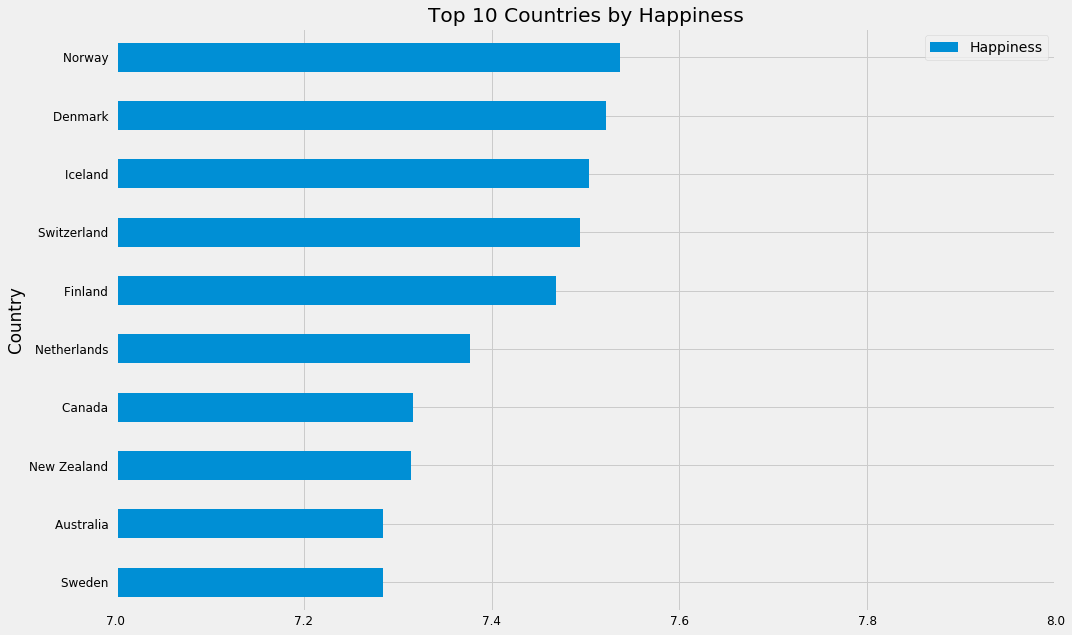

In [154]:
# Plot dataframe

happiness_df.set_index('Country').plot.barh(rot=0, title='Top 10 Countries by Happiness', figsize=(15,10), fontsize=12)
plt.xlim(range(7,9))
plt.gca().invert_yaxis()

plt.savefig("resources/images/Top 10 Countries by Happiness.png")
plt.show()